In [1]:
!pip install keras==2.12.0

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 1.7 MB 11.0 MB/s            
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.13.1 requires keras<2.14,>=2.13.1, but you have keras 2.12.0 which is incompatible.
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


# Utils

In [2]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR

from typing import List

import numpy as np
import pandas as pd

In [3]:
class Pipeline:
    def __init__(self, data: pd.DataFrame) -> None:
        self.data = data
        self.combined_df: pd.DataFrame = None

    def process(self) -> pd.DataFrame:
        timestamps = self.data["timestamp"]
        columns = [
            "light_air",
            "moisture_ground",
            "dht_air_humidity",
            "dht_air_temperature",
            "dht_ground_humidity",
            "dht_ground_temperature",
        ]
        indexes = self.__fix_missing_vaues(timestamps)
        dataframe = self.__add_missing_values(indexes)
        dataframe = self.__detrend(dataframe, columns, 30)
        dataframe = self.__scale(dataframe, columns)

        return dataframe

    def __fix_missing_vaues(self, timestamps: np.ndarray):
        """
        Return array of indexes where values are missing between that index and next.
        """
        t = int(timestamps[0])
        c = 0
        indexes = []
        for i, timestamp in enumerate(timestamps[1:]):
            diff = int(timestamp) - t
            t = int(timestamp)

            # missing data from sensors
            # at least one timestamp is missing
            if diff >= 60:
                indexes.append(i)
                c += diff // 30

        print(f"[+] Total missing values: {c}")

        return indexes

    def __add_missing_values(self, indexes) -> pd.DataFrame:
        """
        Creates a new pandas dataframe with the new values added.
        """

        # Assuming indexes and timestamps are defined somewhere in your code
        cols = self.data.columns
        timestamps = self.data["timestamp"]
        new_data = []

        for index in indexes:
            diff = timestamps[index + 1] - timestamps[index]
            n_values = diff // 30

            if n_values > 0:
                # nan_values = np.full((n_values, len(cols)), np.nan)
                for i in range(n_values):
                    value = [np.nan] * len(cols)
                    value[0] = timestamps[index] + (i + 1) * 30
                    new_data.append(value)

        new_data_df = pd.DataFrame(new_data, columns=cols)
        combined_df = pd.concat([self.data, new_data_df], ignore_index=True)

        combined_df.sort_values("timestamp", inplace=True)
        combined_df.reset_index(drop=True, inplace=True)

        # resolve NaN values
        for col in combined_df.columns:
            combined_df[col] = combined_df[col].interpolate()

        # change moisture for mean of moisture
        # this is because there was a problem with the sensor
        # and the data is inconsistent
        moving_avg = combined_df["moisture_ground"].rolling(window=30).mean()
        combined_df.drop(columns=["moisture_ground"])
        combined_df["moisture_ground"] = moving_avg

        return combined_df

    def __detrend(
        self, data: pd.DataFrame, columns: List[str], window_size: int
    ) -> pd.DataFrame:
        """
        Detrend columns use wants.
        """
        detrended_df = pd.DataFrame()
        for col in columns:
            moving_avg = data[col].rolling(window=window_size).mean()
            detrended_ts = data[col] - moving_avg
            detrended_df[col] = detrended_ts

        detrended_df["timestamp"] = data["timestamp"]
        # get rid of first 30 values because no trend can be calculated thus is filled with NaN values
        detrended_df = detrended_df.dropna()

        return detrended_df

    def __scale(self, data: pd.DataFrame, columns: List[str]) -> pd.DataFrame:
        """
        scale (0, 1)
        """
        scaled_df = pd.DataFrame()
        for col in columns:
            # scaling values
            min_val = data[f"{col}"].min()
            max_val = data[f"{col}"].max()
            scaled_series = (data[f"{col}"] - min_val) / (max_val - min_val)
            scaled_df[col] = scaled_series

        scaled_df["timestamp"] = data["timestamp"]

        return scaled_df

In [4]:
class Ensemble(BaseEstimator):
    def __init__(self, models):
        self.models = models

    def fit(self, X, y):
        for model in self.models:
            model.fit(X, y)

    def predict(self, X):
        predictions = np.array([model.predict(X) for model in self.models])
        return np.mean(predictions, axis=0)

    def evaluate(self, X, y, metric=mean_squared_error):
        preds = self.predict(X)
        return metric(y, preds)


# Setup

In [5]:
test_url = "https://gist.githubusercontent.com/w-dan/5dd47369b014640689e0eeb203e718b8/raw/d973b2a9f2f4f708c6fe644e22d72d36cfd05940/split_test.csv"
train_url = "https://gist.githubusercontent.com/w-dan/5dd47369b014640689e0eeb203e718b8/raw/d973b2a9f2f4f708c6fe644e22d72d36cfd05940/split_train.csv"

train_df = pd.read_csv(train_url)
test_df = pd.read_csv(test_url)

In [6]:
train_df.shape

(9000, 8)

In [7]:
pipe_train_df = Pipeline(train_df)
pipe_test_df = Pipeline(test_df)

In [8]:
train_df = pipe_train_df.process()
test_df = pipe_test_df.process()

y_train = train_df['moisture_ground']
X_train = train_df.drop('moisture_ground', axis=1)
y_test = test_df['moisture_ground']
X_test = test_df.drop('moisture_ground', axis=1)

[+] Total missing values: 483
[+] Total missing values: 169


In [9]:
train_df.shape

(9425, 7)

# Ensemble class

In [16]:
target = "Ground Moisture"

In [10]:
models = [
    RandomForestRegressor(n_estimators=100, random_state=42),
    GradientBoostingRegressor(n_estimators=100, random_state=42),
    SVR(kernel='rbf')
]

# create and evaluate
ensemble_model = Ensemble(models)
ensemble_model.fit(X_train, y_train)

In [11]:
# evaluating
mse = ensemble_model.evaluate(X_test, y_test)
print(f'Ensemble Model MSE: {mse}')

Ensemble Model MSE: 0.02334128185154848


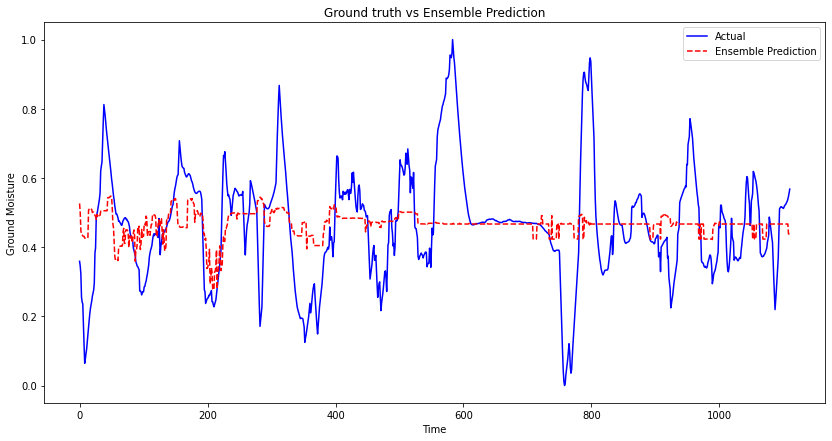

In [12]:
import numpy as np
import matplotlib.pyplot as plt

ensemble_preds = ensemble_model.predict(X_test)

# plot
plt.figure(figsize=(14, 7))
plt.plot(y_test.values, label='Actual', color='blue')
plt.plot(ensemble_preds, label='Ensemble Prediction', color='red', linestyle='--')
plt.legend()
plt.title('Ground truth vs Ensemble Prediction')
plt.xlabel('Time')
plt.ylabel(target)
plt.show()


# Test Case 1: Combining RandomForest and GradientBoosting

Test Case 1 - Ensemble Model MSE: 0.02412772139419421


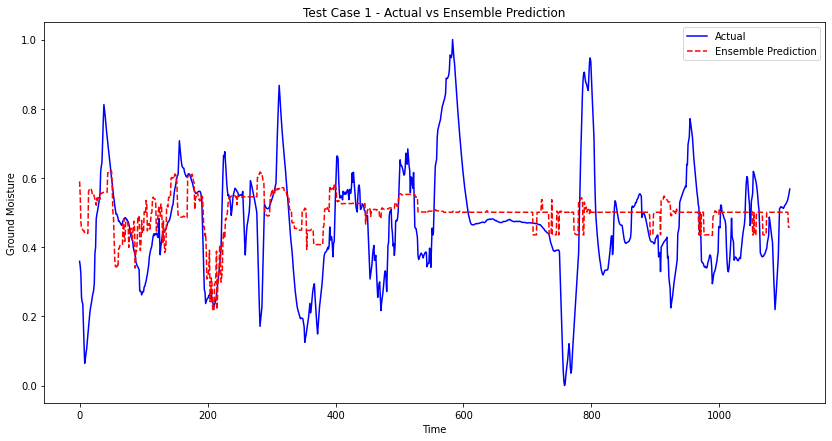

In [17]:

# Create models
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
gb_model = GradientBoostingRegressor(n_estimators=100, random_state=42)

# Create ensemble
ensemble_model = Ensemble([rf_model, gb_model])

# Fit ensemble
ensemble_model.fit(X_train, y_train)

# Evaluate ensemble
mse = ensemble_model.evaluate(X_test, y_test)
print(f'Test Case 1 - Ensemble Model MSE: {mse}')

# Plot predictions
ensemble_preds = ensemble_model.predict(X_test)
plt.figure(figsize=(14, 7))
plt.plot(y_test.values, label='Actual', color='blue')
plt.plot(ensemble_preds, label='Ensemble Prediction', color='red', linestyle='--')
plt.legend()
plt.title('Test Case 1 - Actual vs Ensemble Prediction')
plt.xlabel('Time')
plt.ylabel(target)
plt.show()


# Test Case 2: Adding SVR to the Ensemble

Test Case 2 - Ensemble Model MSE: 0.02334128185154848


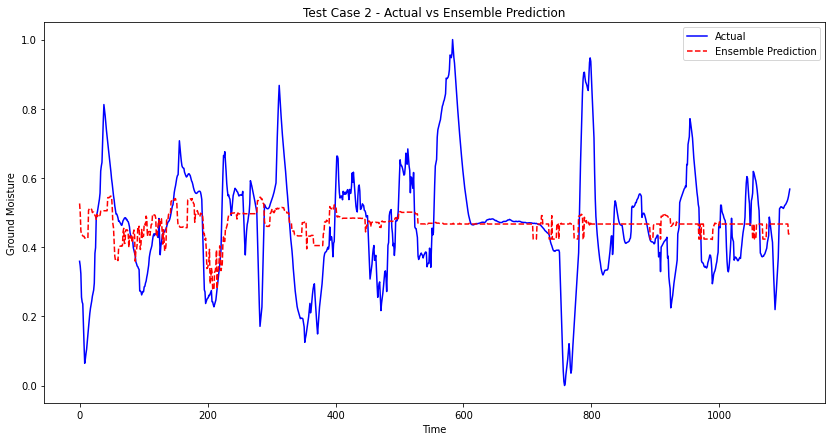

In [18]:

# Create models
svr_model = SVR(kernel='rbf')

# Create ensemble
ensemble_model = Ensemble([rf_model, gb_model, svr_model])

# Fit ensemble
ensemble_model.fit(X_train, y_train)

# Evaluate ensemble
mse = ensemble_model.evaluate(X_test, y_test)
print(f'Test Case 2 - Ensemble Model MSE: {mse}')

# Plot predictions
ensemble_preds = ensemble_model.predict(X_test)
plt.figure(figsize=(14, 7))
plt.plot(y_test.values, label='Actual', color='blue')
plt.plot(ensemble_preds, label='Ensemble Prediction', color='red', linestyle='--')
plt.legend()
plt.title('Test Case 2 - Actual vs Ensemble Prediction')
plt.xlabel('Time')
plt.ylabel(target)
plt.show()


# Test Case 3: Ensemble of Three GradientBoosting Models with Different Parameters

Test Case 3 - Ensemble Model MSE: 0.0031177539050036077


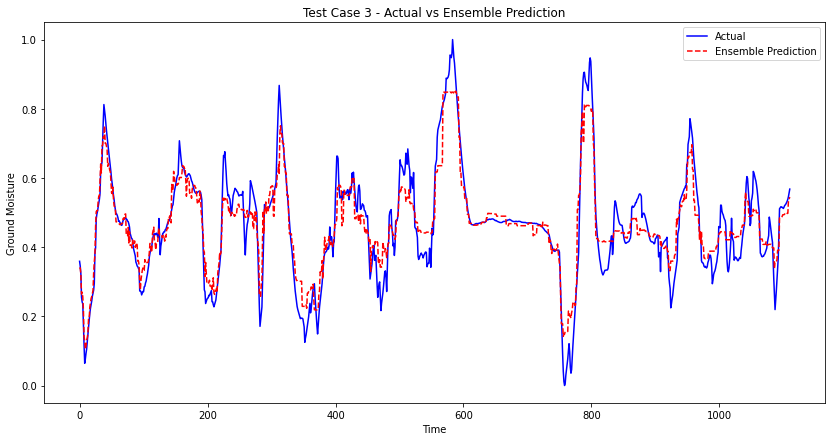

In [21]:

# Create models
gb_model1 = GradientBoostingRegressor(n_estimators=50, random_state=42)
gb_model2 = GradientBoostingRegressor(n_estimators=100, random_state=42)
gb_model3 = GradientBoostingRegressor(n_estimators=150, random_state=42)

# Create ensemble
ensemble_model = Ensemble([gb_model1, gb_model2, gb_model3])

# Fit ensemble
ensemble_model.fit(X_test, y_test)

# Evaluate ensemble
mse = ensemble_model.evaluate(X_test, y_test)
print(f'Test Case 3 - Ensemble Model MSE: {mse}')

# Plot predictions
ensemble_preds = ensemble_model.predict(X_test)
plt.figure(figsize=(14, 7))
plt.plot(y_test.values, label='Actual', color='blue')
plt.plot(ensemble_preds, label='Ensemble Prediction', color='red', linestyle='--')
plt.legend()
plt.title('Test Case 3 - Actual vs Ensemble Prediction')
plt.xlabel('Time')
plt.ylabel(target)
plt.show()


# Test Case 4: Ensemble with Two RandomForest and One SVR

Test Case 4 - Ensemble Model MSE: 0.025519139929385946


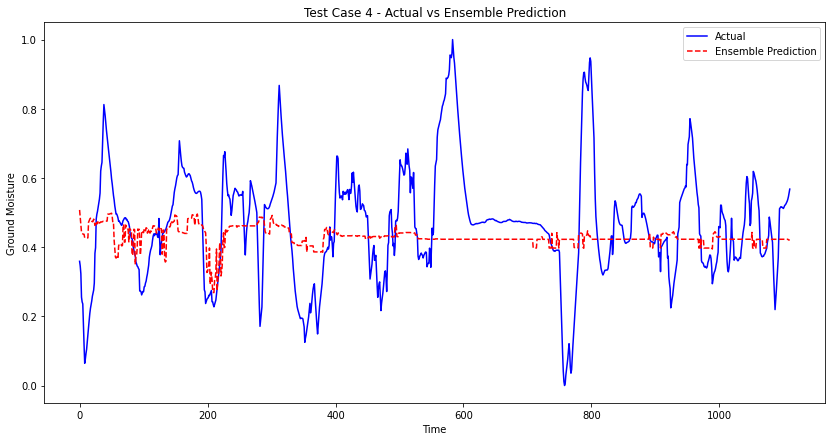

In [22]:

# Create models
rf_model1 = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model2 = RandomForestRegressor(n_estimators=200, random_state=42)
svr_model = SVR(kernel='rbf')

# Create ensemble
ensemble_model = Ensemble([rf_model1, rf_model2, svr_model])

# Fit ensemble
ensemble_model.fit(X_train, y_train)

# Evaluate ensemble
mse = ensemble_model.evaluate(X_test, y_test)
print(f'Test Case 4 - Ensemble Model MSE: {mse}')

# Plot predictions
ensemble_preds = ensemble_model.predict(X_test)
plt.figure(figsize=(14, 7))
plt.plot(y_test.values, label='Actual', color='blue')
plt.plot(ensemble_preds, label='Ensemble Prediction', color='red', linestyle='--')
plt.legend()
plt.title('Test Case 4 - Actual vs Ensemble Prediction')
plt.xlabel('Time')
plt.ylabel(target)
plt.show()


# Test Case 5: Ensemble with Three Different Models

Test Case 5 - Ensemble Model MSE: 0.02334128185154848


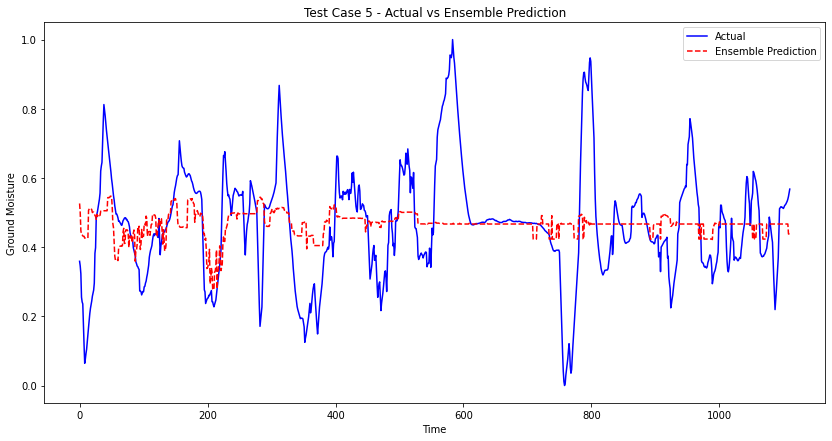

In [24]:

# Create models
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
gb_model = GradientBoostingRegressor(n_estimators=100, random_state=42)
svr_model = SVR(kernel='rbf')

# Create ensemble
ensemble_model = Ensemble([rf_model, gb_model, svr_model])

# Fit ensemble
ensemble_model.fit(X_train, y_train)

# Evaluate ensemble
mse = ensemble_model.evaluate(X_test, y_test)
print(f'Test Case 5 - Ensemble Model MSE: {mse}')

# Plot predictions
ensemble_preds = ensemble_model.predict(X_test)
plt.figure(figsize=(14, 7))
plt.plot(y_test.values, label='Actual', color='blue')
plt.plot(ensemble_preds, label='Ensemble Prediction', color='red', linestyle='--')
plt.legend()
plt.title('Test Case 5 - Actual vs Ensemble Prediction')
plt.xlabel('Time')
plt.ylabel(target)
plt.show()
